# Classifier V1

Idea now: Use pytorch's image encoders and feature extraction

https://pytorch.org/vision/stable/io.html#images

https://pytorch.org/vision/stable/feature_extraction.html



implemented from:
https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py



To do:

*   Try different models
*   Create second mediapipe stream
*   Use CorpusNGT Data as well once received



from google.colab import drive
drive.mount('/content/drive')

In [376]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex

import torchvision.transforms as transforms
from PIL import Image
import torch
from torchvision import models
from torch import nn

Take a look at the categories


In [377]:
path2data = "Data/CorpusNGT/gloss_split/"

listOfCategories = os.listdir(path2data)
listOfCategories, len(listOfCategories)

(['0',
  '1',
  '10',
  '100',
  '1000',
  '11',
  '12',
  '13',
  '14',
  '15',
  '158',
  '16',
  '17',
  '18',
  '19',
  '2',
  '2-ORD',
  '20',
  '22',
  '26',
  '3',
  '3-ORD',
  '30',
  '4',
  '4-ORD',
  '40',
  '5',
  '50',
  '500',
  '500^',
  '6',
  '60',
  '7',
  '70',
  '7UP',
  '8',
  '80',
  '9',
  '90',
  'A',
  'AAL',
  'AAN',
  'AANBELLEN',
  'AANBIEDEN',
  'AANDACHT',
  'AANHALINGSTEKENS',
  'AANKLEDEN',
  'AANKLIKKEN',
  'AANKLOPPEN',
  'AANLEUNEN',
  'AANMOEDIGEN',
  'AANPAKKEN',
  'AANPASSEN',
  'AANRANDEN',
  'AANSLUITEN',
  'AANVALLEN',
  'AANVALLEN-TEAMS',
  'AANWEZIG',
  'AAP',
  'AAPACHTIGEBEWEGINGENMAKEN',
  'AAPNADOEN',
  'AARDIG',
  'ABBEE-LEPEE',
  'ABORTUS',
  'ABORTUS-B',
  'ABTS',
  'ABWZ',
  'ACCENT',
  'ACCEPTEREN',
  'ACCORDEON',
  'ACHTER',
  'ACHTERUITGANG',
  'ADDA',
  'ADEM-INHOUDEN',
  'ADEMEN',
  'ADOLFITLER',
  'ADVIES',
  'AF',
  'AFBLIJVEN',
  'AFHANKELIJK',
  'AFHOUDEN',
  'AFKEUREN',
  'AFPAKKEN',
  'AFRIKA',
  'AFRONDEN',
  'AFSCHEIDEN',
 

In [378]:
for cat in listOfCategories:
    print("category:", cat)
    path2acat = os.path.join(path2data, cat)
    listOfSubs = os.listdir(path2acat)
    print("number of sub-folders:", len(listOfSubs))

category: 0
number of sub-folders: 74
category: 1
number of sub-folders: 1042
category: 10
number of sub-folders: 96
category: 100
number of sub-folders: 70
category: 1000
number of sub-folders: 38
category: 11
number of sub-folders: 40
category: 12
number of sub-folders: 44
category: 13
number of sub-folders: 26
category: 14
number of sub-folders: 24
category: 15
number of sub-folders: 38
category: 158
number of sub-folders: 2
category: 16
number of sub-folders: 8
category: 17
number of sub-folders: 12
category: 18
number of sub-folders: 18
category: 19
number of sub-folders: 26
category: 2
number of sub-folders: 450
category: 2-ORD
number of sub-folders: 64
category: 20
number of sub-folders: 62
category: 22
number of sub-folders: 10
category: 26
number of sub-folders: 4
category: 3
number of sub-folders: 174
category: 3-ORD
number of sub-folders: 20
category: 30
number of sub-folders: 22
category: 4
number of sub-folders: 126
category: 4-ORD
number of sub-folders: 2
category: 40
num

In [379]:
unique_glosses = np.load('Data/CorpusNGT/gloss_labels.npy',allow_pickle='TRUE').item()
#gloss_counter = np.load('Data/CorpusNGT/gloss_counts.npy',allow_pickle='TRUE').item()
print(unique_glosses)

{'GLOSS': 0, 'LANG': 1, 'PO': 2, 'ZONDAG': 3, 'FIETSEN': 4, 'LOPEN': 5, 'WATER': 6, 'SPRINGEN': 7, 'STAAN': 8, 'BEEN': 9, 'GEK': 10, 'HOND': 11, 'DUWEN': 12, 'MOVE': 13, 'MEE': 14, 'GOOIEN': 15, 'KLAAR': 16, 'KLEREN': 17, 'VOCHTIG': 18, 'LACHEN': 19, 'UITKLEDEN': 20, 'VAN': 21, 'BROEK': 22, 'AANKLEDEN': 23, 'AL': 24, 'WACHTEN': 25, 'DROOG': 26, 'WEG': 27, 'BROOD': 28, 'JAM': 29, 'ONDERWIJS': 30, 'INTERNAAT': 31, 'ONGESTELD': 32, 'VERSCHILLENDE': 33, 'DUS': 34, 'ZENUWACHTIG': 35, 'OPGELUCHT': 36, 'BETER': 37, 'VERSLAAN': 38, 'GOED': 39, 'PANTOFFELS': 40, 'BE': 41, 'UUR': 42, 'BINNEN': 43, 'MOETEN': 44, 'LAATSTE': 45, 'PT': 46, 'MOOI': 47, 'HANDEN-WRIJVEN': 48, 'SCHRIKKEN': 49, 'SCHREEUWEN': 50, 'VLUCHTEN': 51, 'KAPOT': 52, 'HOUDEN-VAN': 53, 'SCHOOL': 54, 'ZATERDAG': 55, 'KAART': 56, 'BEZOEK': 57, 'TREIN': 58, 'BRIEF': 59, 'KUNNEN': 60, 'WAAR': 61, 'OPEN': 62, 'GEZELLIG': 63, 'PRATEN': 64, 'VERHAAL': 65, 'PRECIES': 66, 'KERK': 67, 'WIJ': 68, 'GAAN': 69, 'S': 70, 'MOEDER': 71, 'RUIMTE': 7

## 1 SPLIT INTO TEST AND TRAINING SETS

In [550]:
def get_vids(path2data):
    listOfCats = os.listdir(path2data)
    ids = []
    labels = []
    usableListOfCats = []
    for catg in listOfCats:
        path2catg = os.path.join(path2data, catg)
        counter = 0
        if len(os.listdir(path2catg)) > 50:  # We can only use glosses which have more than 50 occurences, meaning more than 25*2 files in dir, since video and frames are in there.
            counter += 1
            listOfSubCats = os.listdir(path2catg)
            path2subCats = [os.path.join(path2catg, los) for los in listOfSubCats if os.path.isdir(os.path.join(path2catg, los))]
            path2subCats = [path for path in path2subCats if len(os.listdir(path)) > 16]
            #print(path2subCats)
            ids.extend(path2subCats)
            labels.extend([catg]*len(path2subCats))
            usableListOfCats.append(catg)
    return ids, labels, usableListOfCats

In [551]:
all_vids, all_labels, catgs = get_vids(path2data)
len(all_vids), len(all_labels), len(catgs)

(69903, 69903, 542)

We have around 1146 classes with more than 5 datapoints in them and about 114815 datapoints total. So an average of 100 instances per class. With the instances per class ranging from 10 to over 500.

In [552]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict

{'0': 0,
 '1': 1,
 '10': 2,
 '100': 3,
 '2': 4,
 '2-ORD': 5,
 '20': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '8': 11,
 'AANBIEDEN': 12,
 'AANDACHT': 13,
 'AANHALINGSTEKENS': 14,
 'AANKLEDEN': 15,
 'AANPASSEN': 16,
 'AANWEZIG': 17,
 'AAP': 18,
 'ABORTUS': 19,
 'ACCEPTEREN': 20,
 'ACHTER': 21,
 'ADEMEN': 22,
 'AF': 23,
 'AFHANKELIJK': 24,
 'AFSPRAAK': 25,
 'AFWEGEN': 26,
 'AL': 27,
 'ALLEEN': 28,
 'ALLEMAAL': 29,
 'ALLES': 30,
 'ALS': 31,
 'ALTIJD': 32,
 'AMERIKA': 33,
 'AMSTERDAM': 34,
 'ANDERE-KANT': 35,
 'ANDERS': 36,
 'ANDERSOM': 37,
 'APART': 38,
 'APPLAUS': 39,
 'ARMEN-OVERLKAAR': 40,
 'AT': 41,
 'AUTO': 42,
 'AUTOMATISCH': 43,
 'AUTORIJDEN': 44,
 'AVOND': 45,
 'BABY': 46,
 'BAL': 47,
 'BALANCEREN': 48,
 'BANAAN': 49,
 'BANG': 50,
 'BASIS': 51,
 'BE': 52,
 'BEDOELEN': 53,
 'BEER': 54,
 'BEETJE': 55,
 'BEGELEIDEN': 56,
 'BEGINNEN': 57,
 'BEGRIJPEN': 58,
 'BELANGRIJK': 59,
 'BESLUITEN': 60,
 'BESTAAN': 61,
 'BESTEMPELEN': 62,
 'BETALEN': 63,
 'BETEKENEN': 64,
 'BETER': 65,
 'BEWIJS':

In [630]:
num_classes = len(catgs)
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids), len(unique_labels)
#print(unique_ids)
#print(unique_labels)

(69903, 69903)

In [631]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

62912 62912
6991 6991


In [632]:
# We've now obtained the paths and labels for all sets of gloss frames that have two or more occurrences of the gloss, and split these into a test and training set

## 2 DEFINE DATASETS AND TRANSFORMS

In [633]:
# Now we have to transform the frames into usable format; tensors

In [634]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [945]:
# Choose model type, this is just a test. For now we pick the R3D_18 ResNet 18 layer model from pytorch that has been pretrained on the Kinetics dataset

#data_type = "image"
data_type = "keypoint"

model_type = "R3D_18"
#model_type = "rnn"

timesteps = 8
if data_type == "image":
    if model_type == "rnn":
        h, w =224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]
else:
    h, w = 33, 3
    # already normalized by mp so no mean needed

In [946]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [947]:
class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2keypoints=glob.glob(self.ids[idx]+"/*.npy")
        path2keypoints = path2keypoints[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2keypoints:
            frame = np.load(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frames_tr.append(torch.from_numpy(frame))
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [948]:
# define helper functions

def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    if model_type != "rnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

def transform_keypoint_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 33, 3
    else:
        h, w = 33, 3
        # already normalized by mp

    test_transformer = transforms.Compose([
                torch.from_numpy()]
        )

    frames_tr = []
    for frame in frames:
        frame = frame
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

TRAIN

In [949]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

if data_type == "image":
    train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
    print(len(train_ds))
else:
    train_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
    print(len(train_ds))

62912


In [950]:
# inspect
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([8, 33, 3]),
 527,
 tensor(-0.6874, dtype=torch.float64),
 tensor(1.6190, dtype=torch.float64))

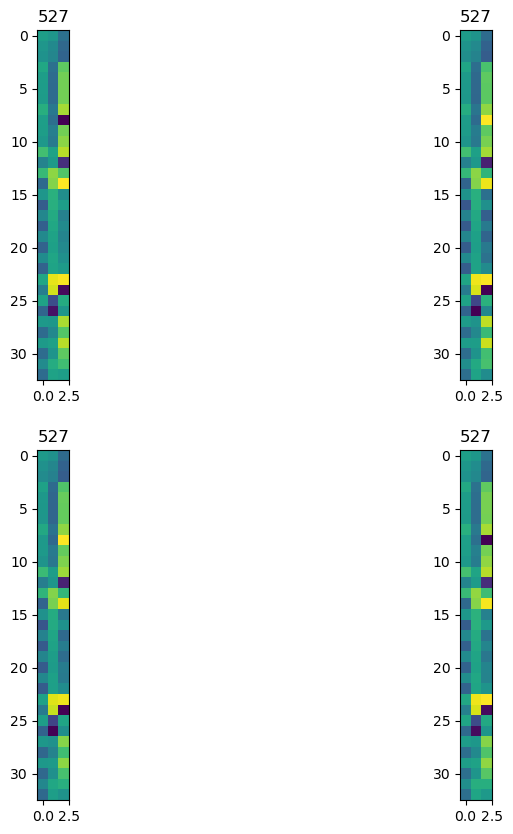

In [951]:
%matplotlib inline

## For image condition, not keypoints

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::2]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

TEST

In [952]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

if data_type == "image":
    test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
    print(len(test_ds))
else:
    test_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
    print(len(train_ds))

62912


In [953]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([8, 33, 3]),
 376,
 tensor(-0.8021, dtype=torch.float64),
 tensor(1.3924, dtype=torch.float64))

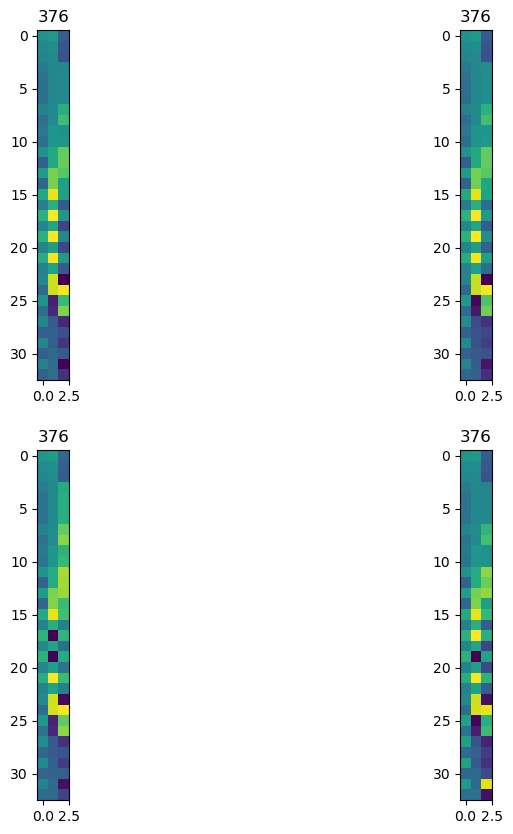

In [954]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::2]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

## 3 DEFINE DATALOADER

We define the custom dataloader for our model; batch and stack the images etc

In [955]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    if data_type == "image":
        imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


batch_size = 10
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [956]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([10, 8, 33, 3]) torch.Size([10])


In [957]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([20, 8, 33, 3]) torch.Size([20])


## 4 DEFINE MODEL

In [958]:
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.r3d_18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out)
        return out

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [959]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 480)
        self.fc2 = nn.Linear(480, 120)
        self.fc3 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [960]:
if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)
else:
    if data_type == "keypoint":
        model = Net()
    else:
        model = models.video.r3d_18(weights='KINETICS400_V1', progress=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

In [961]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(batch_size, 8, 3, h, w)
    else:
        if data_type == "keypoint":
            x = torch.zeros(batch_size, 8, h, w)
        else:
            x = torch.zeros(batch_size, 3, 8, h, w)
    y= model(x)
    print(y.shape)
    print(x.shape)

torch.Size([10, 542])
torch.Size([10, 8, 33, 3])


In [962]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [963]:
model

Net(
  (conv1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=542, bias=True)
)

In [964]:
path2weights = "Models/weights.pt"
torch.save(model.state_dict(), path2weights)

## 5 TRAIN MODEL

## TO DO: PRETRAINING

In [1018]:
import copy
import tqdm

def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()


def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    running_wer=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb.float())
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b

        # GET ACCURACY
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

        # GET WORD ERROR RATE
        

    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights")
            model.load_state_dict(best_model_wts)


        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [1024]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="mean")     # our current loss function is Cross Entropy Loss or CTC Loss.   nn.CrossEntropyLoss(reduction="sum") -->    nn.CTCLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3)        # original lr=3e-5 in baseline paper lr=1e-3. Baseline also uses adam with batch size of 8 and weight decay of 1e-3.
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.8, patience=5, verbose=True)    # patientce is 5, so after 5 epochs of no improvement learning rate is lr*factor, so halved
#lr_scheduler = CosineAnnealingLR(opt, T_max=50)     # maximum amount of iterations on the lr
os.makedirs("Thesis/Models", exist_ok=True)

params_train={
    "num_epochs": 80,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "Models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0/79, current lr=0.001
Copied best model weights
train loss: 0.000091, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 1/79, current lr=0.001
Copied best model weights
train loss: 0.000071, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 2/79, current lr=0.001
Copied best model weights
train loss: 0.000068, dev loss: 0.000081, accuracy: 0.00
----------
Epoch 3/79, current lr=0.001
train loss: 0.000093, dev loss: 0.000081, accuracy: 0.00
----------
Epoch 4/79, current lr=0.001
train loss: 0.000069, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 5/79, current lr=0.001
train loss: 0.000093, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 6/79, current lr=0.001
train loss: 0.000077, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 7/79, current lr=0.001
train loss: 0.000087, dev loss: 0.000082, accuracy: 0.00
----------
Epoch 8/79, current lr=0.001
Epoch 00009: reducing learning rate of group 0 to 8.0000e-04.
Loading best model weights
train loss: 0.000076, dev lo

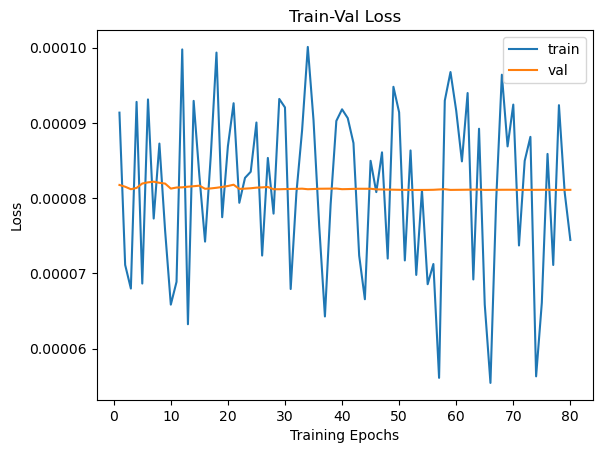

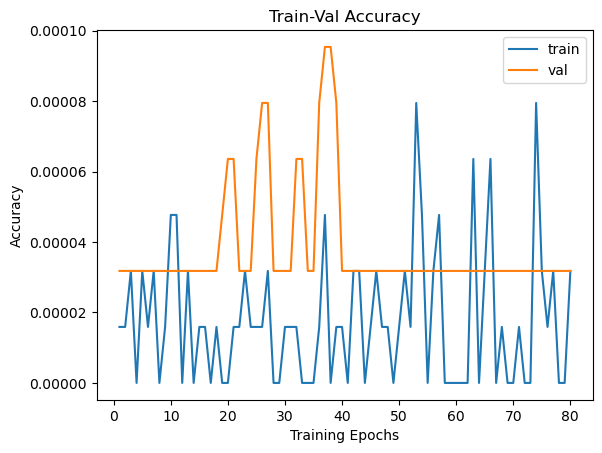

In [1026]:
plot_loss(loss_hist, metric_hist)

## Loss is only marginally improving and accuracy is ~0 at every epoch meaning the model is not getting anything right? --> Not enough data yet.

## 6 TEST MODEL

In [1011]:
def get_model(num_classes, model_type="rnn"):
    if model_type == "rnn":
        params_model={
            "num_classes": num_classes,
            "dr_rate": 0.1,
            "pretrained" : True,
            "rnn_num_layers": 1,
            "rnn_hidden_size": 100,}
        model = Resnt18Rnn(params_model)
    else:
        if data_type == "keypoint":
            x = torch.zeros(1, 8, h, w)
            model = Net()
        else:
            x = torch.zeros(1, 3, 8, h, w)
            model = models.video.r3d_18(pretrained=True, progress=False)
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)
    return model

def get_keypoints(folder, n_frames=8):
    path2keypoints = [os.path.join(folder, keypoint) for keypoint in os.listdir(folder) if keypoint.split(".")[1] == "npy"]
    print(path2keypoints)
    frames = []
    for p2i in path2keypoints:
        frame = np.load(p2i)
        frames.append(frame)

    seed = np.random.randint(1e9)
    frames_tr = []
    for frame in frames:
        random.seed(seed)
        np.random.seed(seed)
        frames_tr.append(torch.from_numpy(frame))
    if len(frames_tr)>0:
        frames_tr = torch.stack(frames_tr)
    return frames_tr, len(frames)

def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv.VideoCapture(filename)
    v_len = int(v_cap.get(cv.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frames.append(frame)
    v_cap.release()
    return frames, v_len

# define helper functions

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [1012]:
model_type = "R3D_18"
model = get_model(model_type = model_type, num_classes = num_classes)
model.eval();

In [1013]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path2weights = "Models/weights_"+model_type+".pt"

model.load_state_dict(torch.load(path2weights))
model.to(device);

In [1014]:
path2vido = "Data/CorpusNGT/gloss_split/AAN/0"
frames, v_len = get_keypoints(path2vido, n_frames=8)
len(frames), v_len

['Data/CorpusNGT/gloss_split/AAN/0\\frame0_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame1_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame2_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame3_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame4_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame5_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame6_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame7_array.npy', 'Data/CorpusNGT/gloss_split/AAN/0\\frame8_array.npy']


(9, 9)

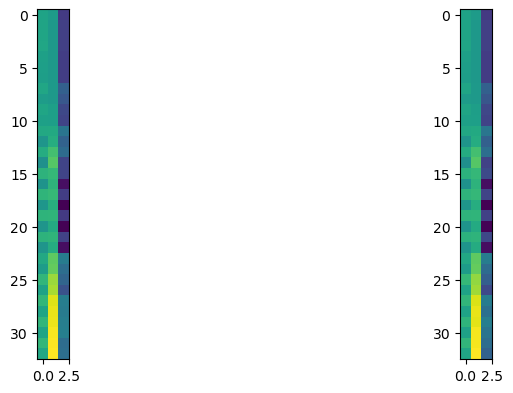

In [1015]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(frames[::5]):
    plt.subplot(2,2,ii+1)
    plt.imshow(img)

In [1017]:
imgs_tensor = transform_keypoint_frames(frames, model_type)
print(imgs_tensor.shape, torch.min(imgs_tensor), torch.max(imgs_tensor))

TypeError: from_numpy() takes exactly one argument (0 given)

In [1010]:
with torch.no_grad():
    out = model(imgs_tensor.to(device)).cpu()
    #print(out)
    pred = torch.argmax(out).item()
    print(pred)
    print(out[0][pred])
    keys = list(labels_dict.keys())
    print(keys[pred])
    print()
    print(out)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 3, 9, 112, 112]